**캐글 집값 데이터 분석**

교재 5.10절, pp. 353-370.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
data=pd.read_csv('train.csv')
data.shape

(1460, 81)

* 데이터 전처리, 선형 회귀

In [9]:
print(data.isnull().sum().sort_values(ascending = False))

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
Id                  0
Length: 81, dtype: int64


분석에 사용하지 않는 Id와 결측값이 많은 5개의 변수는 삭제하자.

In [10]:
drop_data=["Id","Alley","PoolQC","MiscFeature","Fence","FireplaceQu"]
data.drop(columns=drop_data, axis=1, inplace=True)
data.shape

(1460, 75)

남아있는 수치형 변수의 결측값들은 그 변수의 평균으로 대체하자.

In [11]:
data.fillna(data.mean(), inplace = True)

범주형 변수는 OneHot 인코딩을 이용해서 수치형 변수로 만들자.

범주의 수만큼 변수의 수를 만들게 되면 다중공선성의 문제가 생기기 때문에 `drop_first=True` 첫번째 변수를 드랍해서 변수하나를 줄여준다. 즉, k개의 변수중에서 k-1개의 변수만 만든다.

In [12]:
data = pd.get_dummies(data, drop_first=True)
data.shape

(1460, 233)

seaborn의 `distplot()`을 이용해서 target 변수의 분포를 그림으로 그려보자.

<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

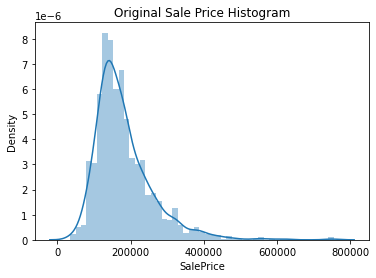

In [14]:
import warnings
warnings.filterwarnings('ignore')

plt.title('Original Sale Price Histogram')
sns.distplot(data['SalePrice'])

대칭이 아니라 오른쪽으로 긴 꼬리를 가진 분포다. 로그 변환시켜보자. 아래 코드에서 `np.log1p()` 함수는 $\log(1+x)$를 계산해준다(왜 $\log(x)$를 안 썼을까?) : `0부터 시작하게 하려고 즉, log1 = 0 이기 때문`. 로그 변환 결과 대칭에 가까운 모양이므로 target변수의 변환값을 data frame에 포함시키면 되겠다.

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

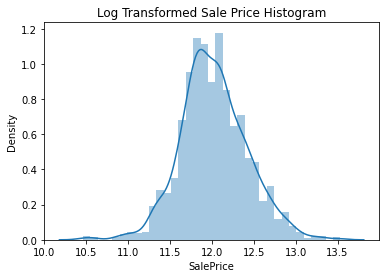

In [15]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(data['SalePrice'])
sns.distplot(log_SalePrice)

In [16]:
original_SalePrice = data['SalePrice']
data['SalePrice'] = np.log1p(data['SalePrice'])

In [17]:
data.isnull().sum().sum()

0

결측값이 1개도 없는 것을 알 수 있다.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = data['SalePrice']
X_data = data.drop(['SalePrice'], axis=1, inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target , random_state=611)

표준화하지 않은 원 데이터로 선형회귀분석


In [19]:
lr = LinearRegression()
lr.fit(X_train ,y_train)

y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

#print('절편 값:',lr.intercept_)
#print('회귀 계수값:', np.round(lr.coef_, 1))

MSE : 0.043 , RMSE : 0.208
Variance score : 0.675


회귀계수를 큰 값부터 정렬하여 10개만 보자.

In [20]:
coeff = pd.Series(lr.coef_, index=X_data.columns )
coeff.sort_values(ascending=False)[:10]

RoofMatl_Membran    3.046516
RoofMatl_Metal      2.901343
RoofMatl_Roll       2.872479
RoofMatl_WdShngl    2.786659
RoofMatl_CompShg    2.782199
RoofMatl_Tar&Grv    2.738233
RoofMatl_WdShake    1.518081
RoofStyle_Shed      1.518081
GarageCond_Po       0.631656
MSZoning_FV         0.441298
dtype: float64

이번에는 feature 변수들을 표준화한 뒤 분석해보자.

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns = data.columns)
data_scaled_df.shape

(1460, 233)

In [22]:
y_scaled = data_scaled_df['SalePrice']
X_scaled = data_scaled_df.drop(['SalePrice'], axis=1, inplace=False)

X_train_scaled , X_test_scaled , y_train_scaled , y_test_scaled = train_test_split(X_scaled , 
                                                                     y_scaled , random_state=611)

In [23]:
X_train_scaled.shape

(1095, 232)

In [24]:
X_test_scaled.shape

(365, 232)

In [25]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)
y_preds = lr.predict(X_test_scaled)

mse = mean_squared_error(y_test_scaled, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
# print('Variance score : {0:.3f}'.format(r2_score(y_test_scaled, y_preds)))
print('훈련 데이터 점수:{0:.3f}'.format(lr.score(X_train_scaled, y_train_scaled)))
print('test 데이터 점수:{0:.3f}'.format(lr.score(X_test_scaled, y_test_scaled)))
#print('절편 값:',lr.intercept_)
#print('회귀 계수값:', np.round(lr.coef_, 1))

MSE : 289996463504432037888.000 , RMSE : 17029282530.525
훈련 데이터 점수:0.953
test 데이터 점수:-347296866610693931008.000


아주 이상한 결과가 나왔다. 무엇이 문제일까? test data에서의 잔차들을 살펴보자.

In [26]:
(y_test_scaled - y_preds)

703     3.584614e-01
742     2.095607e-04
1178    3.874501e-01
4      -3.563622e-01
86     -1.008418e-01
            ...     
451     4.817836e-01
817     7.271117e-03
169     1.341748e+11
1139    5.730144e-01
496    -1.796402e-01
Name: SalePrice, Length: 365, dtype: float64

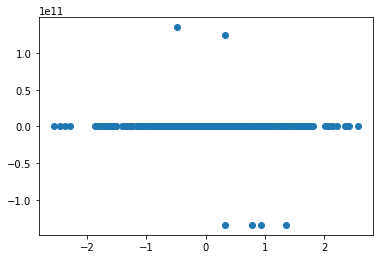

In [27]:
plt.scatter(y_test_scaled, y_preds)

plt.show()

그림을 보니 어마어마하게 큰 예측값들이 몇 개 있다. 큰 값들을 제외하고 다시 그려보자.

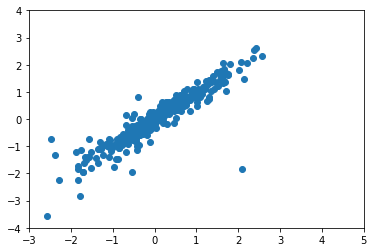

In [28]:
plt.scatter(y_test_scaled, y_preds)
plt.axis([-3, 5, -4, 4])
plt.show()

위의 그림을 보면 회귀모형은 좋은 모형인 것 같다. 즉 비정상적인 몇 개 데이터를 찾아서 적절한 조치를 하면 되겠다. 

In [29]:
np.abs(y_preds).max()

135027535035.1906

In [30]:
np.abs(y_test_scaled - y_preds).max()

135027535035.67311

In [31]:
(np.abs(y_test_scaled - y_preds) >2).sum()

7

In [32]:
y_test_adj = y_test_scaled[np.abs(y_test_scaled - y_preds) <2]
X_test_adj = X_test_scaled[np.abs(y_test_scaled - y_preds) < 2]

y_p_adj = y_preds[np.abs(y_test_scaled - y_preds) <2]

X_test_adj.shape

(358, 232)

In [33]:
mse = mean_squared_error(y_test_adj, y_p_adj)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test_adj, y_p_adj)))

MSE : 0.081 , RMSE : 0.285
Variance score : 0.902


따라서 테스트 데이터에서 비정상적인 예측값이 나온 데이터를 제외하고 보니 결정계수가 높아졌다. 문제가 된 데이터를 찾아보자.

In [34]:
ind = X_test_scaled[np.abs(y_test_scaled - y_preds) >2].index
(y_test_scaled-y_preds)[ind]

825     3.940927e+00
944    -1.350275e+11
471     1.341748e+11
324     1.341748e+11
1230   -1.249192e+11
1024    1.341748e+11
169     1.341748e+11
Name: SalePrice, dtype: float64

그런데 이상한 데이터가 test data에만 들어있을까? 

In [35]:
y_preds_tr = lr.predict(X_train_scaled)

mse = mean_squared_error(y_train_scaled, y_preds_tr)
rmse = np.sqrt(mse)

In [36]:
print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_train_scaled, y_preds_tr)))

MSE : 0.050 , RMSE : 0.224
Variance score : 0.953


In [37]:
(abs(y_train_scaled- y_preds_tr) > 2).sum()

0

train data에서는 MSE, 결정계수값이 아주 좋다. 그런데 test data에서는 다른 결과가 나오는 것으로 볼 때 우리가 만든 회귀모델은 과적합 모델로 판단된다. 그렇다고 해서 아주 나쁜 모델이라고 할 수는 없다. 테스트 데이터에서의 나쁜 성능은 모델보다는 test data에 들어있는 몇몇 특별한 이상치 데이터때문에 생겼기 때문이다.

이제 해야할 일은 위의 분석 결과 등을 이용해서 극단적으로 큰 오차가 생기는 이상치 데이터들을 찾아 그 데이터들을 제외한 다음 다시 회귀 모델을 만드는 것이다.  

그런데 앞서 scale 전처리를 하지 않았을 때에는 이런 극단적인 문제가 생기지 않았다. 하지만 역시 test data에서의 결정계수 값이 상당히 낮은 값이므로 이상치 데이터들이 모델의 성능에 나쁜 영향을 미쳤다고 볼 수 있다. 전처리가 문제가 아니라 이상치가 문제다.


이번에는 표준화하지 않은 원 데이터에서도 이상치를 찾아보자.

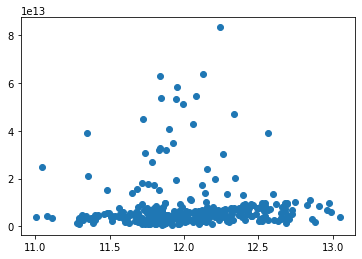

In [38]:
y_preds = lr.predict(X_test)
plt.scatter(y_test, y_preds)
plt.show()

In [39]:
lr.fit(X_train ,y_train)
print('훈련데이터 점수: {0:.3f}'.format(lr.score(X_train, y_train)))
print('test 데이터 점수: {0:.3f}'.format(lr.score(X_test, y_test)))

훈련데이터 점수: 0.953
test 데이터 점수: 0.675


<AxesSubplot:>

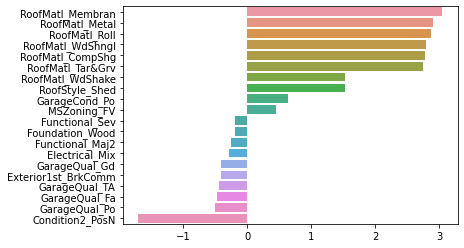

In [40]:
coef = pd.Series(lr.coef_, index = X_data.columns)
coef_h = coef.sort_values(ascending = False).head(10)
coef_l = coef.sort_values(ascending = False).tail(10)
coef_hl = pd.concat([coef_h, coef_l])
sns.barplot(x=coef_hl.values, y=coef_hl.index)

In [41]:
y_preds = lr.predict(X_test)

(np.abs(y_test - y_preds) > 1).sum()

6

잔차가 큰 데이터들을 test data에서 제외하면?

In [42]:
y_test_a = y_test[np.abs(y_test - y_preds) < 1]
X_test_a = X_test[np.abs(y_test - y_preds) < 1]

print('훈련데이터 점수: {0:.3f}'.format(lr.score(X_train, y_train)))
print('test 데이터 점수: {0:.3f}'.format(lr.score(X_test_a, y_test_a)))

훈련데이터 점수: 0.953
test 데이터 점수: 0.902


잔차가 큰 데이터를 제외했더니 예상대로 상당히 성능이 좋아졌다.

## ----기말고사 여기까지----

* ridge, lasso

과대적합이 생긴 모델의 복잡도를 낮추기 위해 규제가 있는 모델을 이용해보자. 데이터는 위에서 찾은 이상치들을 제외하고 표준화하지 않은 원 데이터를 이용한다.

**ridge 회귀**

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 0.1)
ridge.fit(X_train, y_train)

훈련 데이터와 테스트데이터에서 $R^2 $ 값을 구해보자.

In [ ]:
print('훈련 데이터 점수: {}'.format(ridge.score(X_train, y_train)))
print('test 데이터 점수: {}'.format(ridge.score(X_test_a, y_test_a)))

In [ ]:
coef = pd.Series(ridge.coef_, index = X_data.columns)
coef_h = coef.sort_values(ascending = False).head(10)
coef_l = coef.sort_values(ascending = False).tail(10)
coef_hl = pd.concat([coef_h, coef_l])
sns.barplot(x=coef_hl.values, y=coef_hl.index)

훈련데이터에 대해 다소 과대적합되었다고 보고 알파값을 크게 해보자.

In [ ]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)

print('훈련 데이터 점수: {}'.format(ridge.score(X_train, y_train)))
print('test 데이터 점수: {}'.format(ridge.score(X_test_a, y_test_a)))

In [ ]:
ridge = Ridge(alpha = 5)
ridge.fit(X_train, y_train)

print('훈련 데이터 점수: {}'.format(ridge.score(X_train, y_train)))
print('test 데이터 점수: {}'.format(ridge.score(X_test_a, y_test_a)))

In [ ]:
ridge = Ridge(alpha = 10)
ridge.fit(X_train, y_train)

print('훈련 데이터 점수: {}'.format(ridge.score(X_train, y_train)))
print('test 데이터 점수: {}'.format(ridge.score(X_test_a, y_test_a)))

In [ ]:
coef = pd.Series(ridge.coef_, index = X_data.columns)
coef_h = coef.sort_values(ascending = False).head(10)
coef_l = coef.sort_values(ascending = False).tail(10)
coef_hl = pd.concat([coef_h, coef_l])
sns.barplot(x=coef_hl.values, y=coef_hl.index)

**lasso 회귀**

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)

In [ ]:
print('훈련 데이터 점수: {}'.format(lasso.score(X_train, y_train)))
print('test 데이터 점수: {}'.format(lasso.score(X_test_a, y_test_a)))
print("모델에서 이용한 변수의 수: {}".format(np.sum(lasso.coef_ != 0)))

In [ ]:
coef = pd.Series(lasso.coef_, index = X_data.columns)
coef_h = coef.sort_values(ascending = False).head(10)
coef_l = coef.sort_values(ascending = False).tail(10)
coef_hl = pd.concat([coef_h, coef_l])
sns.barplot(x=coef_hl.values, y=coef_hl.index)

과적합 모델이라고 할 수 있다. 알파값을 크게 해보자.

In [ ]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

print('훈련 데이터 점수: {}'.format(lasso.score(X_train, y_train)))
print('test 데이터 점수: {}'.format(lasso.score(X_test_a, y_test_a)))
print("모델에서 이용한 변수의 수: {}".format(np.sum(lasso.coef_ != 0)))

In [ ]:
coef = pd.Series(lasso.coef_, index = X_data.columns)
coef_h = coef.sort_values(ascending = False).head(10)
coef_l = coef.sort_values(ascending = False).tail(10)
coef_hl = pd.concat([coef_h, coef_l])
sns.barplot(x=coef_hl.values, y=coef_hl.index)